# 10 – BOLD5000 Alignment Figures

**Objective.**  
Replicate the key RSA alignment figures from NSD on the **BOLD5000** dataset, which samples 5 000 images from three sources (COCO, ImageNet, and scene-centric images). This allows direct comparison of inter-subject and model-brain alignment across distinct image distributions.

**Dataset splits**  
- **COCO (40%)**: Complex, multi-object, social scenes—mirrors NSD.  
- **ImageNet (40%)**: Complex scenes with more object-centric contex, “natural” images.  
- **Scenes (20%)**: Primarily scene-dominated, minimal objects or social context


## Imports

Load core utilities for file handling, plotting, interpolation, power-law fitting, and standardized aesthetics.


In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Helper function in module to make the notebook more readable
from convergence.operations import interpolate_alignment_series, unpack_scores
from convergence.plotting import plot_faverage_parcelation
from convergence.figures import setup_matplotlib_fonts, plot_cbar_set
from convergence.power_law import fit_powerlaw_zero_with_bootstrap
from convergence.figures_other_datasets import load_alignment

setup_matplotlib_fonts()

## Data paths & file validation

Define paths to **BOLD5000** RSA results (inter-subject and subject-model) for each subset (`all`, `coco`, `imagenet`, `scenes`), both **joined** (hemispheres merged) and **separated**. Assert that all files exist before proceeding.


In [2]:
data_folder = Path("../derivatives")

hcp_filename = data_folder / "metadata" / "hcp.csv"
model_info_filename = data_folder / "metadata" / "models-info.csv"
bold_folder = data_folder / "bold5000"

# Dictionary organizing files as
#  [subset=all|coco|imagente|scenes] x [model|subject] x [joined|separated]
filenames = {
    "all": {
        "subject": {
            "joined": "rsa_bold5000_subject_subject_alignment_joined.parquet",
            "separated": "rsa_bold5000_subject_subject_alignment_separated.parquet",
        },
        "model": {
            "joined": "rsa_bold5000_subject_model_alignment_joined.parquet",
            "separated": "rsa_bold5000_subject_model_alignment_separated.parquet",
        },
    },
    "coco": {
        "subject": {
            "joined": "rsa_bold5000-coco_subject_subject_alignment_joined.parquet",
            "separated": "rsa_bold5000-coco_subject_subject_alignment_separated.parquet",
        },
        "model": {
            "joined": "rsa_bold5000-coco_subject_model_alignment_joined.parquet",
            "separated": "rsa_bold5000-coco_subject_model_alignment_separated.parquet",
        },
    },
    "imagenet": {
        "subject": {
            "joined": "rsa_bold5000-imagenet_subject_subject_alignment_joined.parquet",
            "separated": "rsa_bold5000-imagenet_subject_subject_alignment_separated.parquet",
        },
        "model": {
            "joined": "rsa_bold5000-imagenet_subject_model_alignment_joined.parquet",
            "separated": "rsa_bold5000-imagenet_subject_model_alignment_separated.parquet",
        },
    },
    "scenes": {
        "subject": {
            "joined": "rsa_bold5000-scenes_subject_subject_alignment_joined.parquet",
            "separated": "rsa_bold5000-scenes_subject_subject_alignment_separated.parquet",
        },
        "model": {
            "joined": "rsa_bold5000-scenes_subject_model_alignment_joined.parquet",
            "separated": "rsa_bold5000-scenes_subject_model_alignment_separated.parquet",
        },
    },
}
# Convert the filenames as paths
for subset in ["all", "coco", "imagenet", "scenes"]:
    for modality in ["model", "subject"]:
        for hemispheres in ["joined", "separated"]:
            filename = bold_folder / filenames[subset][modality][hemispheres]
            filenames[subset][modality][hemispheres] = filename
            assert filename.exists(), f"Check {filename.name}"

figure_folder = Path("../figures")
output_folder = figure_folder / "10_bold5000_alignment"
output_folder.mkdir(exist_ok=True)

## ROI ordering

Reuse the **top-30** ROI order defined on NSD (highest within-subject reliability) for all connectivity heatmaps, ensuring consistency across datasets.


In [3]:
connectivity_order = ['V1','V2', 'V3', 'V4', 'V8', 
                      'V3A', 'V3B', 'V3CD', 'VVC', 
                      'VMV3', 'VMV2', 'VMV1', 'PHA1', 'PHA2', 'PHA3', 
                      'IP0', 'PGp', 'DVT', 'LO3', 'LO2', 'PIT', 'LO1', 
                      'FFC', 'PH', 
                      'TPOJ3', 'V4t', 'FST', 'MST', 'MT', 'TPOJ2']

## Surface maps

Generate **cortical flat maps** of:

- Inter-subject RSA  
- Vision-model RSA  
- Language-model RSA  
- Model depth (% of network depth)

for each subset and hemisphere configuration.  
Color scales (`vmin`, `vmax`) are chosen to span the empirical range for each metric:

| Metric               | vmin | vmax |
|----------------------|-----:|-----:|
| Inter-subject RSA    | –0.20| 0.20 |
| Language RSA         | –0.10| 0.10 |
| Vision RSA           | –0.15| 0.15 |
| Vision-model depth   |  0.40| 0.75 |

Views: lateral, medial, ventral.


In [4]:
surface_folder = output_folder / "01_brain_surfaces"
surface_folder.mkdir(exist_ok=True)

vmax = {
    'rsa_intersubject': (-0.2, 0.2),
    'rsa_language': (-0.1, 0.1),
    'rsa_vision': (-0.15, 0.15),
    'depth_vision': (0.4, 0.75),
}
columns = vmax.keys()
views = ["lateral", "medial", "ventral"]
if len(list(surface_folder.glob("01_bold5000_*.png"))) < 144:
    for subset in ["all", "coco", "imagenet", "scenes"]:
        for join_hemispheres in [True, False]:
            hemispheres = ["lh"] if join_hemispheres else ["lh", "rh"]
            join_name = "joined" if join_hemispheres else "separated"
            df_alignment = load_alignment(filenames=filenames,
                                        hcp_filename=hcp_filename,
                                        subset=subset,
                                        joined=join_hemispheres)
            for column in columns:
                cmap = "RdBu_r" if column.startswith("rsa") else "PiYG_r"
                for hemisphere in hemispheres:
                    brain_name = f"01_bold5000_{subset}_{column}_{join_name}_{hemisphere}"
                    brain = plot_faverage_parcelation(
                        df=df_alignment,
                        value_column=column,
                        hemisphere=hemisphere,
                        default_color='lightgray',
                        default_value=None,
                        cmap=cmap,
                        normalize=vmax[column]
                    )
                    for view in views:
                        brain.show_view(view)
                        brain.save_image(surface_folder / f"{brain_name}_{view}.png", mode="rgba")
                    brain.close()

## Quick check

Display one sample PNG (e.g. `all – rsa_intersubject – separated – rh – ventral`) to confirm rendering.


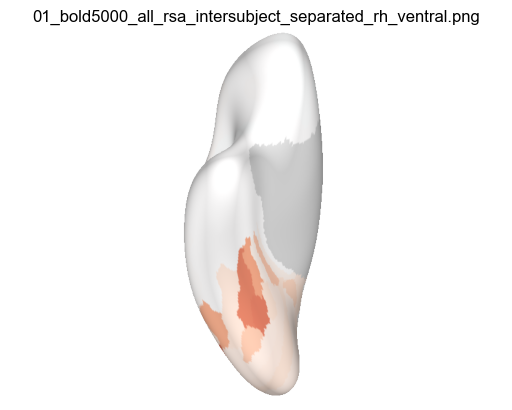

In [5]:
subset = "all" # "all", "coco", "imagenet", "scenes"
column = "rsa_intersubject"# "rsa_intersubject", "rsa_language", "rsa_vision", "depth_vision"
join_name = "separated" # "joined", "separated"
hemisphere = "rh" # "lh", "rh"
view = "ventral" # "lateral", "medial", "ventral"
brain_file = surface_folder / f"01_bold5000_{subset}_{column}_{join_name}_{hemisphere}_{view}.png"
img = plt.imread(brain_file)
fig, ax = plt.subplots()
ax.imshow(img)
ax.set_title(brain_file.name)
ax.axis('off');

## Colorbars

Export standalone colorbars for each metric, matching the ranges used in the surface maps:

- **Inter-subject alignment** (Pearson RSA)  
- **Vision-model alignment**  
- **Language-model alignment**  
- **Vision-model depth** (%)


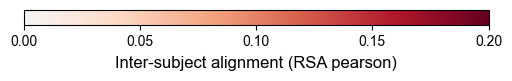

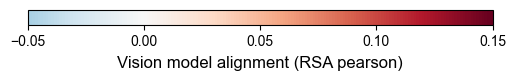

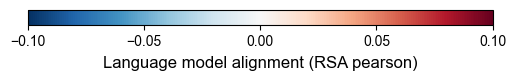

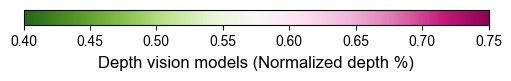

In [6]:
# Intersubject
title="Inter-subject alignment (RSA pearson)"
filename = output_folder / "01_colorbar_intersubject.pdf"
plot_cbar_set(title=title, filename=filename, vmin=0, vmax=0.2, locator=0.05)
# Vision models
title="Vision model alignment (RSA pearson)"
filename = output_folder / "01_colorbar_vision.pdf"
plot_cbar_set(title=title, filename=filename, vmin=-0.05, vmax=0.15, locator=0.05)
# Language models
title="Language model alignment (RSA pearson)"
filename = output_folder / "01_colorbar_language.pdf"
plot_cbar_set(title=title, filename=filename, vmin=-0.1, vmax=0.1, locator=0.05)
# Language models
title="Depth vision models (Normalized depth %)"
filename = output_folder / "01_colorbar_vision_depth.pdf"
plot_cbar_set(title=title, filename=filename, vmin=0.4, vmax=0.75, locator=0.05, cmap="PiYG_r", simmetric=False)

## Scatter & power-law relation

Compare **per-ROI** inter-subject RSA vs. vision-model RSA. Fit a **zero-intercept power law** with bootstrapped 95 % CI:

$$
y = a\,x^b
\quad\text{(fit over positive-shifted data)}
$$

Overlay:

- Scatter points colored by HCP area.  
- Best-fit curve + CI ribbon.  
- R² and parameter estimates in legend.

This parallels the power-law relation observed in NSD.


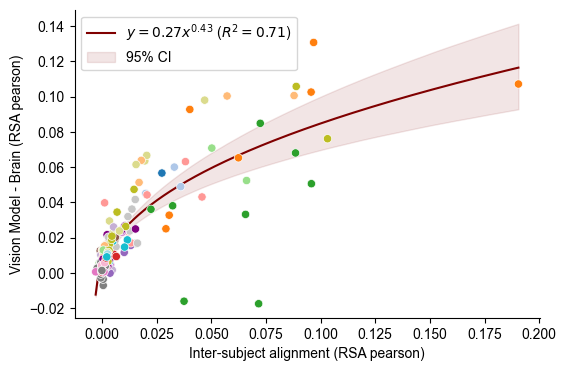

In [7]:
# Get data 
subset = "all"  # "all", "coco", "imagenet", "scenes"
df_alignment = load_alignment(filenames=filenames, hcp_filename=hcp_filename,
                              subset=subset, joined=True)

x = "rsa_intersubject" # "rsa_intersubject", "rsa_language", "rsa_vision"
y = "rsa_vision" # "rsa_intersubject", "rsa_language", "rsa_vision"
xlabel = "Inter-subject alignment (RSA pearson)"
ylabel = "Vision Model - Brain (RSA pearson)"
add_fit = True
x_value = df_alignment[x].to_numpy()
y_value = df_alignment[y].to_numpy()

# To avoid adjust a log-model with negative values. After reversed
x_min = df_alignment[x].min() - 0.0001
y_min = df_alignment[y].min() - 0.0001

# Adjust the power-law
x_fit, y_fit, y_lower, y_upper, r_squared, params = fit_powerlaw_zero_with_bootstrap(
    x_value - x_min, y_value - y_min, n_boot=10000)


fig, ax = plt.subplots(1, 1, figsize=(6, 4))

if add_fit:
    legend = f"$y={params[0]:.2f}x^{{{params[1]:.2f}}}$ ($R^2={r_squared:.2f}$)"
    ax.plot(x_fit+x_min, y_fit+y_min, color="maroon", zorder=-10, label=legend)
    ax.fill_between(x_fit+x_min, y_lower+y_min, y_upper+y_min, color="maroon", alpha=0.1, zorder=-10, label="95% CI")
    ax.legend()

# Add the palette used in the rest of the paper coloured based on anatomical regions
palette = df_alignment.set_index("name").area_color.to_dict()
sns.scatterplot(
    data=df_alignment,
    x=x,
    y=y,
    ax=ax,
    hue="name",
    palette=palette,
    legend=False
)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
sns.despine(ax=ax)

output_file =  f"02_scatter_comparison_{x}_{y}_{subset}.pdf"
fig.savefig(output_folder / output_file, transparent=True, bbox_inches="tight")

## Layerwise interpolation curves

For each DNN layer, we compute RSA per ROI → **interpolate** to a uniform [0,1] “depth” scale → average across subjects and **summary curves** for key ROIs:

- **Early Visual** (V1, V2)  
- **Ventral Hub** (VMV2, PHA1)  
- **LOTC** (MST, TPOJ2)  

In [8]:
subset = "all"
filename = filenames[subset]["model"]["joined"]
df_models = pd.read_parquet(filename)
df_models = df_models.groupby(["subject", "model", "roi", "layer"]).similarity.mean().reset_index()
df_models["max_layer"] = df_models.groupby("model")["layer"].transform("max")
df_models["depth"] = df_models["layer"] / df_models["max_layer"]
max_layer = 41

df_models = df_models.rename(columns={"similarity": "score"})
df_interpolated = interpolate_alignment_series(df_models, groups=["subject", "roi", "model"])
df_interpolated = unpack_scores(df_interpolated)


df_interpolated["modality"] = df_interpolated["model"].str.startswith("vit").map({True: "Vision", False: "Language"})

df_interpolated = df_interpolated.groupby(["modality", "subject", "roi", "layer"]).score.mean().reset_index()
df_interpolated["depth"] = df_interpolated["layer"] / (max_layer - 1)

hcp = pd.read_csv(hcp_filename)

df_interpolated = df_interpolated.merge(hcp[["roi", "name", "area_id", "area_color", "area"]], on="roi", how="inner")

Plot separate subplots for **Vision** vs. **Language** models, with error bars (±SE across subjects).


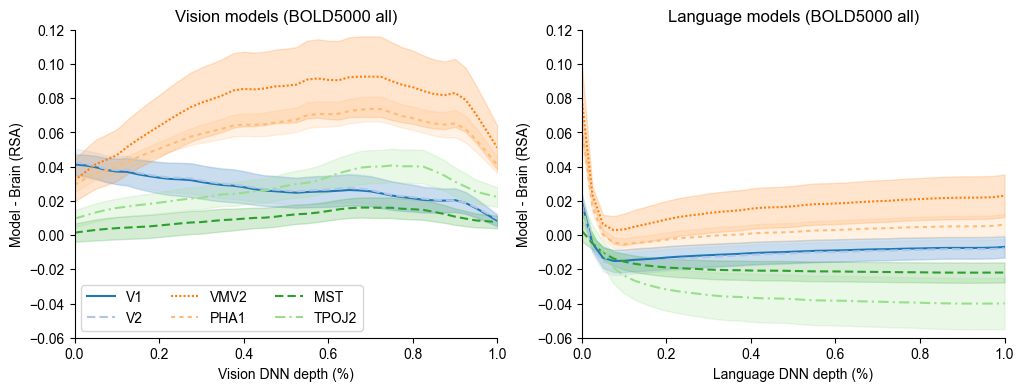

In [9]:

# Plot the main areas
roi_names = ["V1", "V2", "VMV2", "PHA1", "MST", "TPOJ2"]
palette = hcp.query("name in @roi_names and roi <= 180").set_index("name").area_color.to_dict()
dashes={"V1": (None, None), "V2": (4, 2), "VMV2": (1, 1), "PHA1": (2, 2), "MST": (4, 2), "TPOJ2": (5, 2, 1, 2)}

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax , modality in zip (axes, ("Vision", "Language")):
    data = df_interpolated.query("modality == @ modality and name in @roi_names")
    sns.lineplot(data=data, hue="name", x="depth", y="score", hue_order=roi_names, errorbar='se', style="name", palette=palette, ax=ax, dashes=dashes)
    ax.legend(title="", ncol=3)
    ax.set_xlim(0, 1)
    sns.despine(ax=ax)
    ax.set_xlabel(f"{modality} DNN depth (%)")
    ax.set_ylabel("Model - Brain (RSA)")
    ax.set_title(f"{modality} models (BOLD5000 {subset})")
    ax.set_ylim(-0.06, 0.12)

axes[1].legend_.remove()

output_filename = f"03_hierarchical_curves_{subset}.pdf"
fig.savefig(output_folder / output_filename, bbox_inches="tight", transparent=True)


## Connectivity matrices

For each subset, average **inter-subject RSA** over all subject pairs (diagonal only) → build **30×30** connectivity matrices for the ROIs in our predefined order.  
Plot a heatmap (RdBu_r, centered at zero) to visualize the characteristic visual vs. LOTC hub block structure.  

**Observation:**  
- `all`, `coco`, `imagenet` show clear two-stream blocks (early visual vs. LOTC).  
- `scenes` lacks this pattern—mirrors “non-social” NSD split.


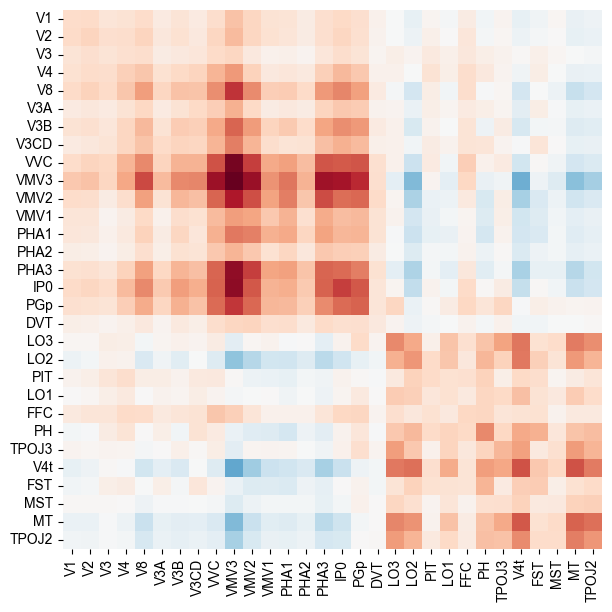

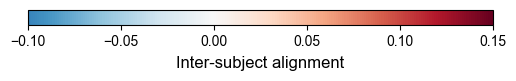

In [10]:
cmap = "RdBu_r"
subset = "all" # 'all', 'coco', 'imagenet', 'scenes'

filename = filenames[subset]["subject"]["joined"]
df_subject = pd.read_parquet(filename)
df_subject = df_subject.groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()
hcp = pd.read_csv(hcp_filename)
hcp = hcp[["roi", "name"]]
df_subject = df_subject.merge(hcp, left_on="roi_x", right_on="roi", how="left", suffixes=("", "_x"))
df_subject = df_subject.rename(columns={"name": "name_x"}).drop(columns=["roi"])
df_subject = df_subject.merge(hcp, left_on="roi_y", right_on="roi", how="left", suffixes=("", "_y"))
df_subject = df_subject.rename(columns={"name": "name_y"}).drop(columns=["roi_y"])
df_subject_selected = df_subject.query("name_x in @connectivity_order and name_y in @connectivity_order").copy()
# pivot
df_subject_selected = df_subject_selected.pivot(index="name_x", columns="name_y", values="similarity")
df_subject_selected = df_subject_selected.loc[connectivity_order, connectivity_order]

fig, ax = plt.subplots(figsize=(7, 7))
vmax = round(float(df_subject_selected.max().max()), 2)
vmax = 0.15
sns.heatmap(data=df_subject_selected, vmin=-vmax, vmax=vmax, center=0, cmap=cmap, square=True, cbar=False,
            xticklabels=df_subject_selected.columns,
            yticklabels=df_subject_selected.index, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("")
output_filename = f"04_rsa_bold5000_subject_{subset}_heatmap_{vmax:.2f}.pdf"
fig.savefig(output_folder / output_filename, bbox_inches="tight", transparent=True)

# Colorbar for the connectivity
title="Inter-subject alignment"
output_file = "04_colorbar_{vmax:.2f}.pdf"
plot_cbar_set(title=title, filename=output_folder / output_file, vmax=vmax, vmin=-0.1, locator=0.05)

## Conclusion

1. **Spatial patterns** (surface maps) and **hub structure** (connectivity blocks) generalize from NSD to BOLD5000.  
2. **Image distribution matters**: social‐scene datasets (`all`, `coco`) drive LOTC–visual segregation; pure scene sets do not.  
3. **Model alignment** (vision/language) and **depth effects** are qualitatively similar across datasets.  
